# OFDM Fundamentals

In this notebook, the fundamentals of Orthogonal Frequency Division Multiplexing (OFDM) are introduced. OFDM is a digital multi-carrier modulation method that is used in several wireless communications standards, such as the IEEE 802.11 family (Wi-Fi), 4G Long Term Evolution (LTE) and most recently 5G New Radio (NR). 

In OFDM, a high rate symbol stream (QPSK, QAM etc.) is transmitted as a combination of several parallel low rate streams, that each modulate a different orthogonal sub-carrier. This approach leads to a low complexity channel equalisation process in the receiver and the use of orthogonal sub-carriers prdocues a very spectrally efficient transmission.  

The orthogonal modulation and demodulation processes are equivalent to the Inverse Discrete Fourier Transform (IDFT) and DFT respectively, allowing OFDM to be implemented efficiently using Fast Fourier Transform (FFT) algorithms. The use of independent sub-carriers also leads to a convenient multiple access scheme, where the available sub-carriers are shared among several different users.

## OFDM Transmitter

In this section, we will go through each step of the OFDM moudlation process. A high level overview of an OFDM transmitter is shown below:




In [1]:
# Import necessary libraries 
import numpy as np 
import matplotlib.pyplot as plt
import math

To begin with, let us define the modulation scheme and symbol rate of the initial high rate symbol stream:

In [2]:
mod_scheme = '16-QAM' # Modulation scheme 
fs = 1e6 # Initial symbol rate

In OFDM systems, the baseband modulation scheme is Quadrature Amplitude Modulation (QAM). It can vary from 2-QAM or BPSK at the lowest to 1024-QAM or higher in the latest standards. Using higher levels of QAM allows for a greater amount of data to be transmitted within a specific bandwidth. The rate of the initial symbol stream is denoted by $f_{s}$, since it is equivalent to the sampling rate in OFDM systems. We can now define the number of sub-carriers: 

In [3]:
N = 64 # No. of sub-carriers 
deltaf = fs/N # Sub-carrier spacing

The number of sub-carriers is chosen such that the channel frequency repsonse is effectively constant across the sub-carrier bandwidth. This facilitates simplified frequency domain equalisation of each sub-carrier in the receiver. The process of equalising several parallel sub-carriers in the frequeny domain is much more computationally efficient than the time domain equalisation traditionally used in single carrier systems.

Notice that the number of sub-carriers has been set to a power of 2. This is because later we'll show that OFDM is implemented using FFT algorithms, which use power of 2 lengths. The sub-carrier spacing, $\Delta f$, is set to the minimum spacing required to maintain orthogonality between sub-carriers. Orthogonality is useful because it allows tight overlap of sub-carriers in frequency, leading to a very spectrally efficient transmission. Moreover, it eliminates the requirement for expensive filters in both transmitter and receiver to keep the sub-channels separated. 

**Baseband Symbol Generation**

At this stage, we will generate a stream of data symbols i.e. BPSK, QPSK or 16-QAM. We will generate enogh symbols to create a total of 100 OFDM symbols:

In [4]:
n_ofdm = 500 # No. of OFDM symbols  
nsym = n_ofdm * N # No. of data symbols (BPSK,QPSK,16-QAM)

In [5]:
# Function to randomly generate a block of BPSK or QPSK synbols
def symbol_gen(mod_scheme,nsym):
    
    if mod_scheme == 'BPSK':
        # 1 bit per symbol for BPSK 
        m = 1  
        M = 2 ** m 
    
        # BPSK symbol values
        bpsk = [-1+0j, 1+0j]
        
        # Generate random integers 
        ints = np.random.randint(0,M,nsym)
        
        # Generate BPSK symbols 
        data = [bpsk[i] for i in ints]
        data = np.array(data,np.complex64)

    elif mod_scheme == 'QPSK': 
        # 2 bits per symbol for QPSK 
        m = 2
        M = 2 ** m 
    
        # QPSK symbol values 
        qpsk = [1+1j, -1+1j, 1-1j, -1-1j] / np.sqrt(2)
        
        # Generate random integers 
        ints = np.random.randint(0,M,nsym)
    
        # Map to QPSK symbols 
        data = [qpsk[i] for i in ints]
        data = np.array(data,np.complex64)
        
    elif mod_scheme == '16-QAM': 
        # 4 bits per symbol for 16-QAM 
        m = 4 
        M = 2 ** m 
        
        # 16-QAM symbol values  
        qam16 = [-3-3j, -3-1j, -3+3j, -3+1j,  \
                -1-3j, -1-1j, -1+3j, -1+1j,  \
                 3-3j,  3-1j,  3+3j,  3+1j,  \
                 1-3j,  1-1j,  1+3j,  1+1j] / np.sqrt(10)
        
        # Generate random integers 
        ints = np.random.randint(0,M,nsym)
        
        # Map to 16-QAM symbols 
        data = [qam16[i] for i in ints]
        data = np.array(data,np.complex64)
        
    else: 
        raise Exception('Modulation method must be BPSK, QPSK or 16-QAM.')
    
    return data 

# Generate BPSK, QPSK or 16-QAM symbols
data_serial = symbol_gen(mod_scheme,nsym)

**Serial to Parallel Converter**

The high rate symbol stream is now converted into $\textit{N}$ parallel lower rate symbol streams using a serial to parallel converter: 

In [6]:
data_parallel = np.zeros((N,n_ofdm),np.complex64) # Matrix to hold parallel low rate data streams 
j= 0

# Serial to Parallel converter
for i in range(n_ofdm):
    data_parallel[:,i] = data_serial[j:j+N]
    j = j + N

**Sub-carrier Modulation**

At this stage, each lower rate symbol stream modulates an individual orthogonal sub-carrier and the resulting waveforms are summed to produce the OFDM symbol. Note, all sub-carriers are being used to transmit data symbols. However, in real systems, this is not the case. For example, pilot sub-carriers are often embedded in the OFDM symbol for synchronisation and channel estimation tasks in the receiver. The construction of an OFDM symbol can be expressed mathematically as: 

$$x[n]=\sum_{k=0}^{N-1} X[k]e^{j2 \pi k (\Delta f / f_{s}) n}$$ 

where $x[n]$ is the OFDM signal, $X[k]$ is the $k^{th}$ input symbol, $\Delta f$ is the sub-carrier spacing, $\textit{n}$ is the sample index and $\textit{k}$ is the sub-carrier index. We can now generate the sub-carriers:  

In [7]:
sc = np.zeros((N,N),np.complex64) # Matrix to hold sub-carriers 
k = np.arange(N) # Define sub-carrier indices i.e. [0,1....N-1]
n = k # No. of time domain OFDM symbols 

# Generate sub-carriers  
for i in range(N):
    sc[i,:] = np.exp(1j*2*math.pi*k[i]*(deltaf/fs)*n)

The sub-carriers are then modulated by the data symbols: 

In [8]:
# Modulate sub-carriers with data symbols   
sc_mod = np.zeros((N,n_ofdm*N),np.complex64)
j = 0

for i in range(n_ofdm):
    sc_mod[:,j:j+N] = sc * data_parallel[:,i][:, np.newaxis]
    j = j + N

Finally, the sub-carriers are summed to create the OFDM symbols: 

In [9]:
ofdm_data = np.sum(sc_mod,0,np.complex64)/N

** Plot spectra of individual sub-carriers **

**Modulation using the IFFT**

In practice, the orthogonal modulation process shown above requires $\textit{N}$ complex oscillators at both transmitter and receiver. This makes this form of multi-carrier modulation prohibitivley costly as $\textit{N}$ increases. However, this cost can be reduced signiciantly if we realise that the modulation and demodulation processes are equivalent to an IDFT and DFT respectively. As such, we can implement OFDM using FFT algorithms, which are much more computationally efficient. 

As it turns out, it is quite easy to prove that the OFDM modulation process is equivalent to an IDFT. Recall, that the sub-carrier spacing for OFDM, $\Delta_{f}$, is given by: 

$$\Delta_{f} = \frac{f_{s}}{N}$$

If we substitute (2) into (1), (1) reduces to:

$$x[n]=\sum_{k=0}^{N-1} X[k]e^{j2 \pi k n / N}$$

which is the equation for the IDFT. 

We can now compare the OFDM symbols generated using the orthogonal modulation process with the symbols generated by the IFFT to show that they are equivalent:  

In [10]:
# Define function to modulate using IFFT 
def ifft_mod(symbols,N):
    ofdm_data = np.fft.ifft(symbols,N)
    return ofdm_data

#  Generate OFDM symbols using IFFT modulation   
ofdm_data_ifft = np.zeros(n_ofdm*N,np.complex64)
j = 0

for i in range(n_ofdm):    
    ofdm_data_ifft[j:j+N] = ifft_mod(data_serial[j:j+N],N)
    j = j + N  

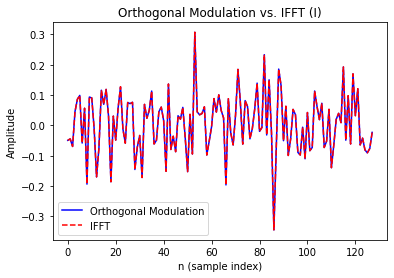

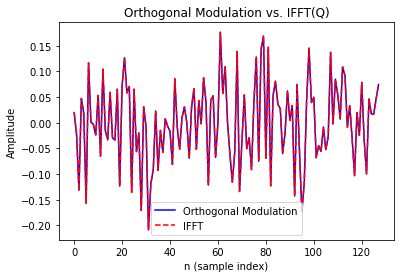

In [11]:
# Compare OFDM symbols generated using orthogonal modulation and IFFT respectively
plt.plot(ofdm_data[0:(2*N)].real,'b')
plt.plot(ofdm_data_ifft[0:(2*N)].real,'--r')
plt.title('Orthogonal Modulation vs. IFFT (I)')
plt.xlabel('n (sample index)')
plt.ylabel('Amplitude')
plt.legend(('Orthogonal Modulation','IFFT'))

plt.figure(2)

plt.plot(ofdm_data[0:(2*N)].imag,'b')
plt.plot(ofdm_data_ifft[0:(2*N)].imag,'--r')
plt.title('Orthogonal Modulation vs. IFFT(Q)')
plt.xlabel('n (sample index)')
plt.ylabel('Amplitude')
plt.legend(('Orthogonal Modulation','IFFT'))

The plots show that the data produced using orthogonal modulation is equivalent to the IFFT. The Mean Squared Error (MSE) between the data streams can be calculated as:   

In [12]:
mse = np.mean(abs(ofdm_data-ofdm_data_ifft)**2)
mse

3.5797148e-16

**Cyclic Prefix**

After performing the IFFT, the final stage in OFDM is the addition of a Cyclic Prefix (CP). One of the primary benefits of OFDM is the simplified equalisation that results from dividing a wideband channel into several parallel narrowband sub-carriers. In addition, the use of orthogonal sub-carriers increases spetcral efficiency. Unfortunatley, in practice, time dispersion caused by multipath propgation destroys the sub-carrier orthogonality and introduces Inter Symbol Interference (ISI). Thus, these benefits are lost. 

However, these problems are resolved by adding a guard interval between OFDM symbols. This interval is made to be longer than the channel delay spread i.e. the diffence in time between the first and final multipath arrivals. Since the OFDM symbols themselves are much longer than the delay spread, the guard interval can be formed by extracting a portion of the OFDM symbol and appennding it to the front, creating the so-called Cyclic Prefix. This process is illusrated below. 

With the addition of a CP, the OFDM symbol consists of the CP and the data carrying portion of the symbol. The data carrying portion is known as the useful symbol.  

The use of a CP prevents discontinuties between the guard interval and the useful symbol. The receiver FFT window can also include a portion of the CP, since this only causes a trivial phase shift to the underlying data symbols, which can subsequently be corrected in the equalisation stage. This relaxes the required accuracy of timing synchronisation in the receiver. However, the FFT window cannot include any portrion of the CP that has absorbed ISI.  

In [13]:
# Define function to add CP 
def add_cp(use_symb,N,cp_len):
    
    #Extract CP
    cp = use_symb[N-cp_len:N:1]
    
    # Concatenate CP and useful symbol 
    ofdm_symb = np.concatenate((cp,use_symb),0)
    
    return ofdm_symb

cp_len = N // 4 # CP length is 1/4 of useful symbol period

# Add CP to each of the useful ofdm symbols 
txSig = np.zeros(n_ofdm*(N+cp_len),np.complex64)
j = 0
k = 0 

for i in range(n_ofdm):    
    txSig[k:(k+N+cp_len)] = add_cp(ofdm_data_ifft[j:j+N],N,cp_len)
    j = j + N  
    k = k + N + cp_len 

The original diagram of the OFDM transmitter can now be updated to include the IFFT and addition of CP:

## Wireless Channel
At this stage, we will pass the OFDM signal through an Additive White Gaaussian Noise (AWGN) channel. The power of the noise  is determined by the Signal to Noise ratio (SNR), secified in dB. 

In [14]:
SNR = 25 # Desired SNR (dB) 
s_p = np.mean(abs(txSig)**2) # signal power 
n_p = s_p/(10 **(SNR/10)) # noise power

# Complex AWGN noise
noise = np.random.normal(0,np.sqrt(n_p/2),len(txSig)) + \
        np.random.normal(0,np.sqrt(n_p/2),len(txSig))

# Add signal and noise 
rxSig = txSig + noise

## OFDM Receiver 

In the receiver, the underlying data symbols (BPSK,QPSK,QAM etc) are recovered using the FFT (since IFFT was used for modulation). The receiver processing is illustrated below: 

In a practical receiver, we must first perform timing synchronisation to find the location of the OFDM symbols in the received signal. Timing synchronisation is achieved by sending special OFDM symbols whose location and contents are known to the receiver. In this example, we know the exact positioning of the OFDM symbols in the received signal. In addition, frequency synchronisation is required to correct for oscillator offsets and Doppler shifts which cause a loss of orthogonality. Before the FFT, we discard the CP as it does not contain any information. However, as mentioned previously, the FFT window may include a portion of the CP if timing synchronisation is not 100% accurate. 

In [15]:
# Function to dem OFDM 
def ofdm_demod(ofdm_rx,N,cp_len):
    
    # Extract useful OFDM symbol 
    ofdm_u = ofdm_rx[cp_len:(N+cp_len)]
    
    # Perform FFT 
    data = np.fft.fft(ofdm_u,N)
    
    return data

# Recover data symbols
data_rx = np.zeros(n_ofdm*N,np.complex64)
j = 0
k = 0 

for i in range(n_ofdm):
    data_rx[j:j+N] = ofdm_demod(rxSig[k:(k+N+cp_len)],N,cp_len)
    j = j + N
    k = k + N + cp_len 

Having removed the CP and performed FFT demodulation, we  can now plot the received BPSK or QPSK constellations:

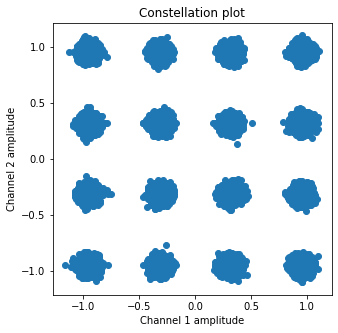

In [16]:
def scatterplot(x, y, ax=None):
    if ax is None:
        plt.figure(figsize=(5,5))
        ax = plt.gca()
    ax.scatter(x,y)
    ax.set_title('Constellation plot')
    ax.set_xlabel('Channel 1 amplitude')
    ax.set_ylabel('Channel 2 amplitude')
    return ax

scatterplot(data_rx.real,data_rx.imag,ax=None)

In addition to viewing the received constellation, signal quality can be measured quantitatively using Error Vector Magnitude (EVM), as described in the notebook on baseband modulation.   

In [17]:
# Function to calculate EVM 
def calculate_evm(symbols_tx, symbols_rx):
    evm_rms = np.sqrt(np.mean(np.abs(symbols_rx - symbols_tx )**2)) / \
              np.sqrt(np.mean(np.abs(symbols_tx)**2))
    
    return evm_rms*100

In [18]:
print("EVM: {:.2f}%".format(calculate_evm(data_serial, data_rx)))

EVM: 5.66%


You should notice that as SNR decreases, the EVM will increase due to the poorer received signal quality.  